<h1><big><center>Audio Denoising </center></big></h1>


### Name : Souhaiel Ben Salem
### email : souhaiel.ben_salem@ens-paris-saclay.fr

We tackle the audio denoising task by training a UNet to separate the noise from a noisy audio and reconstruct the ooriginal audio by substracting the predicted noise magnitude spectogram from the magnitude spectogram of the noisy audio and applying an inverse STFT.

In [ ]:
import torch
import torchvision
import torch.nn as nn
from torchsummary import summary
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
from PIL import ImageOps, ImageFilter
import numpy as np
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode
import matplotlib.pyplot as plt
import pickle
from PIL import Image
from pathlib import Path
import math
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import os
import torch.distributed as dist
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import librosa
import numpy as np
import os
import soundfile as sf
from scipy import stats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_clean_audio = "/content/drive/MyDrive/TP4 denoising/train-speech/train"
train_noise = "/content/drive/MyDrive/TP4 denoising/train-noise/train"

In [ ]:
# Extract the clean speech /noise files
!unzip "/content/drive/MyDrive/TP4 denoising/voix_train.zip" -d "/content/drive/MyDrive/TP4 denoising/train-speech"
!unzip "/content/drive/MyDrive/TP4 denoising/bruit_train.zip" -d "/content/drive/MyDrive/TP4 denoising/train-noise"

In [ ]:
print("number of clean speech files",len([entry for entry in os.listdir(train_clean_audio) if os.path.isfile(os.path.join(train_clean_audio, entry))]))
print("number of noise  files",len([entry for entry in os.listdir(train_noise) if os.path.isfile(os.path.join(train_noise, entry))]))

number of clean speech files 2118
number of noise  files 1874


In [ ]:
def scaled_input(matrix_spec):
    matrix_spec = (matrix_spec + 50)/50
    return matrix_spec

def scaled_output(matrix_spec):
    matrix_spec = (matrix_spec -3 )/82
    return matrix_spec

def inv_scaled_innput(matrix_spec):
    matrix_spec = matrix_spec * 50 - 50
    return matrix_spec

def inv_scaled_output(matrix_spec):
    matrix_spec = matrix_spec * 82 + 3
    return matrix_spec

### Necessary functions

In [ ]:
# transform an audio file into a stack of frames
def audio_to_frame(audio_file, frame_length, sliding_win):
    sequence_length = audio_file.shape[0]
    audio_list = [audio_file[start:start + frame_length] for start in range(0, sequence_length - frame_length + 1, sliding_win)]
    return np.vstack(audio_list)

def audio_files_to_numpy(audio_dir, list_audio_files, sample_rate, frame_length, sliding_win):
    list_sound_array = []

    for file in list_audio_files:
        y, sr = librosa.load(os.path.join(audio_dir, file), sr=sample_rate)
        list_sound_array.append(audio_to_frame( y, frame_length, sliding_win))
    return np.vstack(list_sound_array)


# add noise randomly with intensity ranging from 0.8 to 1.5
def mix_audio_noise(audio, noise, num_frames, frame_length):
    audio_gen = np.zeros((num_frames, frame_length))
    noise_gen = np.zeros((num_frames, frame_length))
    noisy_signal = np.zeros((num_frames, frame_length))
    for i in range(num_frames):
        audio_idx = np.random.randint(0, audio.shape[0])
        noise_idx = np.random.randint(0, noise.shape[0])
        intensity = np.random.uniform(0.4, 0.1)
        audio_gen[i, :] = audio[audio_idx, :]
        noise_gen[i, :] = intensity * noise[noise_idx, :]
        noisy_signal[i, :] = audio_gen[i, :] + noise_gen[i, :]

    return audio_gen, noise_gen, noisy_signal


# returns the magnitude and phase of an audio from its spectogram
def get_magnitude_phase(n_fft, hop_length_fft, audio):

    stftaudio = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length_fft)
    stftaudio_magnitude, stftaudio_phase = librosa.magphase(stftaudio)

    stftaudio_magnitude_db = librosa.amplitude_to_db(
        stftaudio_magnitude, ref=np.max)

    return stftaudio_magnitude_db, stftaudio_phase


def magnitude_phase_to_audio(frame_length, hop_length_fft, stftaudio_magnitude_db, stftaudio_phase):

    stftaudio_magnitude_rev = librosa.db_to_amplitude(stftaudio_magnitude_db, ref=1.0)
    audio_reverse_stft = stftaudio_magnitude_rev * stftaudio_phase
    audio_reconstruct = librosa.core.istft(audio_reverse_stft, hop_length=hop_length_fft, length=frame_length)

    return audio_reconstruct

def spectrogram_to_audio(m_mag_db, m_phase, frame_length, hop_length_fft)  :

    list_audio = []
    nb_spec = m_mag_db.shape[0]
    for i in range(nb_spec):

        audio_reconstruct = magnitude_phase_to_audio(frame_length, hop_length_fft, m_mag_db[i], m_phase[i])
        list_audio.append(audio_reconstruct)

    return np.vstack(list_audio)

def audio_to_matrix_spectrogram(numpy_audio, dim_square_spec, n_fft, hop_length_fft):

    nb_audio = numpy_audio.shape[0]

    m_mag_db = np.zeros((nb_audio, dim_square_spec, dim_square_spec))
    m_phase = np.zeros((nb_audio, dim_square_spec, dim_square_spec), dtype=complex)

    for i in range(nb_audio):
        m_mag_db[i, :, :], m_phase[i, :, :] = get_magnitude_phase(
            n_fft, hop_length_fft, numpy_audio[i])

    return m_mag_db, m_phase

In [ ]:
# Parameters
sr = 8000 # 8 kHz
frame_length = 8064
sliding_win = 8064
hop_length_frame_noise = 5000
frames = 5000 # the more the better
n_fft = 255    # length of the windowed signal after padding with zeros
hop_length_fft = 63 # number of audio samples between adjacent STFT columns.
path_to_time_series = "/content/drive/MyDrive/sinal-processing-project/time-series/"
path_to_sound = "/content/drive/MyDrive/sinal-processing-project/sound/"
path_to_spectrogram = "/content/drive/MyDrive/sinal-processing-project/spectrogram/"

In [ ]:
audio_files = os.listdir(train_clean_audio)
noise_files = os.listdir(train_noise)
audio_list = []
noise_list = []

# clean audio
for file in audio_files:
    aud, sr = librosa.load(os.path.join(train_clean_audio, file), sr=sr)
    audio_list.append(audio_to_frame( aud, frame_length, sliding_win))
audio = np.vstack(audio_list)

# noise
for file in noise_files:
    nois, sr = librosa.load(os.path.join(train_noise, file), sr=sr)
    noise_list.append(audio_to_frame( nois, frame_length, sliding_win))
noise = np.vstack(noise_list)

# Adding noise
audio_gen, noise_gen, noisy_audio= mix_audio_noise(audio, noise, frames, frame_length)




# save concatenated audio
noisy_audio_concat = noisy_audio.reshape(1, frames * frame_length)

sf.write(path_to_sound + 'noisy_audio_concat.wav', noisy_audio_concat[0, :], sr)
audio_concat = audio_gen.reshape(1, frames * frame_length)
sf.write(path_to_sound + 'audio_concat.wav', audio_concat[0, :], sr)
noise_concat = noise_gen.reshape(1, frames * frame_length)
sf.write(path_to_sound + 'noise_concat.wav', noise_concat[0, :], sr)





## DATA GENERATION : Generate and save spectrograms (magnitude + phase)

### Audio

In [ ]:
# spectrogram dimensions
dim_square_spec = int(n_fft / 2) + 1

# Amplitude and Phase

# audio
## begin
audio_extension = audio_gen.shape[0]
audio_mag = np.zeros((audio_extension, dim_square_spec, dim_square_spec)) # magnitude
audio_phase = np.zeros((audio_extension, dim_square_spec, dim_square_spec), dtype=complex) # phase
for i in range(audio_extension):
    audio_mag[i, :, :], audio_phase[i, :, :] = get_magnitude_phase(n_fft, hop_length_fft, noise_gen[i])
np.save(path_to_spectrogram + 'audio_mag', audio_mag)
np.save(path_to_spectrogram + 'audio_phase', audio_phase)
# end

### Noise

In [ ]:
# noise
## begin
noise_extension = noise_gen.shape[0]
noise_mag = np.zeros((noise_extension, dim_square_spec, dim_square_spec))
noise_phase = np.zeros((noise_extension, dim_square_spec, dim_square_spec), dtype=complex)
for i in range(noise_extension):
    noise_mag[i, :, :], noise_phase[i, :, :] = get_magnitude_phase(n_fft, hop_length_fft, audio_gen[i])

np.save(path_to_spectrogram + 'noise_mag', noise_mag)
np.save(path_to_spectrogram + 'noise_phase', noise_phase)
# end

### Noisy audio

In [ ]:
# noisy audio
## begin
noisy_audio_extension = noisy_audio.shape[0]
noisy_audio_mag = np.zeros((noisy_audio_extension, dim_square_spec, dim_square_spec))
noisy_audio_phase = np.zeros((noisy_audio_extension, dim_square_spec, dim_square_spec), dtype=complex)
for i in range(noisy_audio_extension):
    noisy_audio_mag[i, :, :], noisy_audio_phase[i, :, :] = get_magnitude_phase(n_fft, hop_length_fft, noisy_audio[i])
np.save(path_to_spectrogram + 'noisy_audio_mag', noisy_audio_mag)
np.save(path_to_spectrogram + 'noisy_audio_phase', noisy_audio_phase)
# end

In [ ]:
# Save files
np.save(path_to_time_series + 'audio_ts', audio_gen)
np.save(path_to_time_series + 'noise_ts', noise_gen)
np.save(path_to_time_series + 'noisy_audio_ts', noisy_audio)

# U-Net for audio denoising

## PyTorch Implementation

In [ ]:
class U_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.lrelu = nn.LeakyReLU(negative_slope=0.2)
        self.conv12 = nn.LazyConv2d(out_channels=16,kernel_size=2,stride=(1,1),padding='same')
        self.conv1 = nn.LazyConv2d(out_channels=16,kernel_size=3,stride=(1,1),padding='same')
        self.conv11 = nn.LazyConv2d(out_channels=16,kernel_size=3,stride=(1,1),padding='same')
        self.conv111 = nn.LazyConv2d(out_channels=16,kernel_size=3,stride=(1,1),padding='same')
        self.maxpool = nn.MaxPool2d((2,2))
        self.conv2 = nn.LazyConv2d(out_channels=32,kernel_size=3,stride=(1,1),padding='same')
        self.conv22up = nn.LazyConv2d(out_channels=32,kernel_size=2,stride=(1,1),padding='same')
        self.conv22 = nn.LazyConv2d(out_channels=32,kernel_size=3,stride=(1,1),padding='same')
        self.conv222 = nn.LazyConv2d(out_channels=32,kernel_size=3,stride=(1,1),padding='same')
        self.conv3 = nn.LazyConv2d(out_channels=64,kernel_size=3,stride=(1,1),padding='same')
        self.conv33 = nn.LazyConv2d(out_channels=64,kernel_size=3,stride=(1,1),padding='same')
        self.conv333 = nn.LazyConv2d(out_channels=64,kernel_size=3,stride=(1,1),padding='same')
        self.dropout = nn.Dropout(0.5)
        self.conv4 = nn.LazyConv2d(out_channels=128,kernel_size=3,stride=(1,1),padding='same')
        self.conv44 = nn.LazyConv2d(out_channels=128,kernel_size=3,stride=(1,1),padding='same')
        self.conv444 = nn.LazyConv2d(out_channels=128,kernel_size=3,stride=(1,1),padding='same')
        self.conv5 = nn.LazyConv2d(out_channels=256,kernel_size=3,stride=(1,1),padding='same')
        self.conv55 = nn.LazyConv2d(out_channels=256,kernel_size=3,stride=(1,1),padding='same')
        self.conv555 = nn.LazyConv2d(out_channels=256,kernel_size=3,stride=(1,1),padding='same')
        self.upsampling = nn.Upsample(scale_factor =(2,2))
        self.conv6 = nn.LazyConv2d(out_channels=2,kernel_size=3,stride=(1,1),padding='same')
        self.conv7 = nn.LazyConv2d(out_channels=1,kernel_size=1,stride=(1,1),padding='same')
        self.conv54 = nn.LazyConv2d(out_channels=128,kernel_size=2,stride=(1,1),padding='same')
        self.conv32 = nn.LazyConv2d(out_channels=64,kernel_size=2,stride=(1,1),padding='same')

        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.conv1(x)
        x = self.lrelu(x)
        x = self.conv11(x)
        x1 = self.lrelu(x)
        x = self.maxpool(x1)

        x = self.conv2(x)
        x = self.lrelu(x)
        x = self.conv22(x)
        x2 = self.lrelu(x)
        x = self.maxpool(x2)

        x = self.conv3(x)
        x = self.lrelu(x)
        x = self.conv33(x)
        x3 = self.lrelu(x)
        x = self.maxpool(x3)

        x = self.conv4(x)
        x = self.lrelu(x)
        x = self.conv44(x)
        x = self.lrelu(x)
        x_drop = self.dropout(x)
        x = self.maxpool(x_drop)

        x = self.conv5(x)
        x = self.lrelu(x)
        x = self.conv55(x)
        x = self.lrelu(x)
        x = self.dropout(x)

        x_up = self.upsampling(x)
        x_up = self.conv54(x_up)
        x_up = self.lrelu(x_up)
        x_merge1 = torch.cat((x_drop, x_up), dim=1)
        x = self.conv444(x_merge1)
        x = self.lrelu(x)
        x = self.conv44(x)
        x = self.lrelu(x)
        x_up2 = self.upsampling(x)
        x_up2 = self.conv32(x_up2)
        x_up2 = self.lrelu(x_up2)
        x_merge2 = torch.cat((x3, x_up2), dim=1)
        x = self.conv333(x_merge2)
        x = self.lrelu(x)
        x = self.conv33(x)
        x = self.lrelu(x)
        x = self.upsampling(x)
        x = self.conv22up(x)
        x_up3 = self.lrelu(x)
        x_merge3 = torch.cat((x2, x_up3), dim=1)
        x = self.conv222(x)
        x = self.lrelu(x)
        x = self.conv22(x)
        x = self.lrelu(x)

        x_up4 = self.upsampling(x)
        x_up4 = self.conv12(x_up4)
        x_up4 = self.lrelu(x_up4)
        x_merge4 = torch.cat((x1, x_up4), dim=1)
        x = self.conv111(x_merge4)
        x = self.lrelu(x)
        x = self.conv11(x)
        x = self.lrelu(x)
        x = self.conv6(x)
        x = self.lrelu(x)
        x = self.conv7(x)
        out = self.tanh(x)

        return out

In [ ]:
model1 = U_Net().cuda()
summary(model1, (1,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             160
         LeakyReLU-2         [-1, 16, 128, 128]               0
            Conv2d-3         [-1, 16, 128, 128]           2,320
         LeakyReLU-4         [-1, 16, 128, 128]               0
         MaxPool2d-5           [-1, 16, 64, 64]               0
            Conv2d-6           [-1, 32, 64, 64]           4,640
         LeakyReLU-7           [-1, 32, 64, 64]               0
            Conv2d-8           [-1, 32, 64, 64]           9,248
         LeakyReLU-9           [-1, 32, 64, 64]               0
        MaxPool2d-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          18,496
        LeakyReLU-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,928
        LeakyReLU-14           [-1, 64,

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
inp = torch.rand(1, 1,128, 128).cuda()
print(model1(inp).shape)

torch.Size([1, 1, 128, 128])


In [ ]:
# load data
X_in = np.load(path_to_spectrogram +'noisy_audio_mag.npy')
X_ou = np.load(path_to_spectrogram + 'audio_mag.npy')
# noise
X_ou = X_in - X_ou

#Check distribution
print(stats.describe(X_in.reshape(-1,1)))
print(stats.describe(X_ou.reshape(-1,1)))

DescribeResult(nobs=327680000, minmax=(array([-80.]), array([0.])), mean=array([-48.91115673]), variance=array([218.34075461]), skewness=array([0.22974927]), kurtosis=array([-0.06294553]))
DescribeResult(nobs=327680000, minmax=(array([-80.]), array([77.92860821])), mean=array([-10.03703497]), variance=array([185.48588326]), skewness=array([0.22616955]), kurtosis=array([-0.03895421]))


We scale to [-1,1], as scaling is a needed pre-processing step as mentioned in the article : https://medium.com/using-cnn-to-classify-audio/effects-of-spectrogram-pre-processing-for-audio-classification-a551f3da5a46

In [ ]:
# Scale to [-1,1]
X_in = -1 + 2* (X_in +80)/(80)
X_ou = -1 + 2* (X_ou +80)/(78+80)
print(stats.describe(X_in.reshape(-1,1)))
print(stats.describe(X_ou.reshape(-1,1)))

DescribeResult(nobs=327680000, minmax=(array([-1.]), array([1.])), mean=array([-0.22277892]), variance=array([0.13646297]), skewness=array([0.22974927]), kurtosis=array([-0.06294553]))
DescribeResult(nobs=327680000, minmax=(array([-1.]), array([0.99909631])), mean=array([-0.11439285]), variance=array([0.02972054]), skewness=array([0.22616955]), kurtosis=array([-0.03895421]))


In [ ]:
# load data
X_in = np.load('/content/drive/MyDrive/sinal-processing-project/spectogram/noisy_voice_amp_db.npy')
X_ou = np.load('/content/drive/MyDrive/sinal-processing-project/spectogram/voice_amp_db.npy')
# noise
X_ou = X_in - X_ou

#Check distribution
print(stats.describe(X_in.reshape(-1,1)))
print(stats.describe(X_ou.reshape(-1,1)))
# Scale to [1,1]
X_in = scaled_input(X_in)
X_ou = scaled_output(X_ou)

DescribeResult(nobs=81920000, minmax=(array([-80.]), array([0.])), mean=array([-50.09063744]), variance=array([229.63890262]), skewness=array([0.25145882]), kurtosis=array([-0.13898873]))
DescribeResult(nobs=81920000, minmax=(array([-76.0737]), array([72.5340954])), mean=array([2.61653424]), variance=array([52.96059301]), skewness=array([1.39687674]), kurtosis=array([4.69389232]))


In [ ]:
X_in = X_in[:,:,:]
X_in = X_in.reshape(X_in.shape[0],1,X_in.shape[1],X_in.shape[2])
X_ou = X_ou[:,:,:]
X_ou = X_ou.reshape(X_ou.shape[0],1,X_ou.shape[1],X_ou.shape[2])


train_size_Xin = int(0.8 * len(X_in))
test_size_Xin = len(X_in) - train_size_Xin
train_Xin, test_Xin = torch.utils.data.random_split(X_in, [train_size_Xin, test_size_Xin])


train_size_Xout = int(0.8 * len(X_ou))
test_size_Xout = len(X_ou) - train_size_Xout
train_Xout, test_Xout = torch.utils.data.random_split(X_ou, [train_size_Xout, test_size_Xout])


### Plot some examples

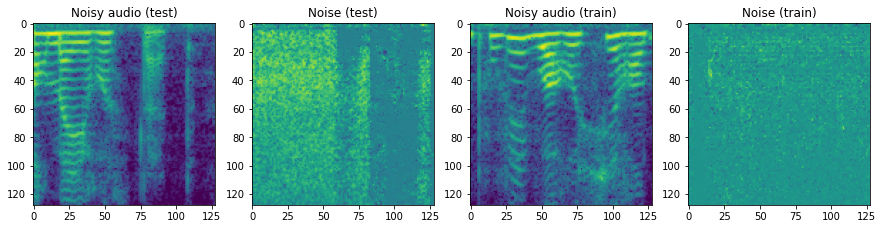

In [ ]:
fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4)
index = 13
fig.set_figheight(6)
fig.set_figwidth(15)
ax1.imshow(np.squeeze(test_Xin[index]))
ax2.imshow(np.squeeze(test_Xout[index]))
ax3.imshow(np.squeeze(train_Xin[index]))
ax4.imshow(np.squeeze(train_Xout[index]))
ax1.title.set_text('Noisy audio (test)')
ax2.title.set_text('Noise (test)')
ax3.title.set_text('Noisy audio (train)')
ax4.title.set_text('Noise (train)')

In [ ]:
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, noisy_audio, noise):
        self.noisy_audio = noisy_audio
        self.noise = noise

    def __len__(self):
        return len(self.noise)

    def __getitem__(self, idx):
        noisy_aud = self.noisy_audio[idx]
        nois = self.noise[idx]
        return noisy_aud, nois

train_dataset = AudioDataset(train_Xin, train_Xout)
test_dataset = AudioDataset(test_Xin, test_Xout)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
len(train_Xout)


16000

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = U_Net().to(device)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
num_epochs = 200
learning_rate = 0.001

In [ ]:
ckpts_path = "/content/drive/MyDrive/sinal-processing-project/checkpoints/unet_mod_best.pt"

In [ ]:
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
def train(model, train_loader,test_loader, num_epochs, learning_rate):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    test_history =[]
    train_history =[]
    lowest_loss = 10
    for epoch in range(num_epochs):
        train_loss = 0.0
        model.train()

        for x, y in tqdm(train_loader):
            x = x.float().to(device)
            y = y.float().to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs,y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()


        train_loss /= len(train_loader)
        train_history.append(train_loss)

        test_loss = 0.0
        test_acc = 0.0
        model.eval()

        for a,b in test_dataloader:
            a = a.float().to(device)
            b = b.float().to(device)
            outputs = model(a)
            loss = criterion(outputs, b)

            test_loss += loss.item()


        test_loss /= len(test_loader)
        if(lowest_loss == 10 or test_loss<lowest_loss):
          print(f'loss improved from {lowest_loss:.5f} to {test_loss:.5f}')
          lowest_loss = test_loss
          print('saving model ...')
          torch.save(model.state_dict(), ckpts_path)
        test_history.append(test_loss)



        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    return train_history, test_history





In [ ]:
train(model, train_dataloader, test_dataloader, num_epochs, learning_rate)

100%|██████████| 63/63 [00:12<00:00,  5.14it/s]


loss improved from 10.00000 to 0.09547
saving model ...
Epoch 1, Train Loss: 0.1099, Test Loss: 0.0955


100%|██████████| 63/63 [00:12<00:00,  5.07it/s]


loss improved from 0.09547 to 0.07220
saving model ...
Epoch 2, Train Loss: 0.0839, Test Loss: 0.0722


100%|██████████| 63/63 [00:12<00:00,  5.11it/s]


loss improved from 0.07220 to 0.05407
saving model ...
Epoch 3, Train Loss: 0.0632, Test Loss: 0.0541


100%|██████████| 63/63 [00:12<00:00,  5.15it/s]


loss improved from 0.05407 to 0.04032
saving model ...
Epoch 4, Train Loss: 0.0472, Test Loss: 0.0403


100%|██████████| 63/63 [00:12<00:00,  5.15it/s]


loss improved from 0.04032 to 0.03017
saving model ...
Epoch 5, Train Loss: 0.0353, Test Loss: 0.0302


100%|██████████| 63/63 [00:12<00:00,  5.14it/s]


loss improved from 0.03017 to 0.02287
saving model ...
Epoch 6, Train Loss: 0.0266, Test Loss: 0.0229


100%|██████████| 63/63 [00:12<00:00,  5.10it/s]


loss improved from 0.02287 to 0.01778
saving model ...
Epoch 7, Train Loss: 0.0204, Test Loss: 0.0178


100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


loss improved from 0.01778 to 0.01430
saving model ...
Epoch 8, Train Loss: 0.0161, Test Loss: 0.0143


100%|██████████| 63/63 [00:12<00:00,  4.93it/s]


loss improved from 0.01430 to 0.01197
saving model ...
Epoch 9, Train Loss: 0.0133, Test Loss: 0.0120


100%|██████████| 63/63 [00:12<00:00,  4.97it/s]


loss improved from 0.01197 to 0.01044
saving model ...
Epoch 10, Train Loss: 0.0114, Test Loss: 0.0104


100%|██████████| 63/63 [00:12<00:00,  5.03it/s]


loss improved from 0.01044 to 0.00945
saving model ...
Epoch 11, Train Loss: 0.0101, Test Loss: 0.0095


100%|██████████| 63/63 [00:12<00:00,  5.05it/s]


loss improved from 0.00945 to 0.00883
saving model ...
Epoch 12, Train Loss: 0.0093, Test Loss: 0.0088


100%|██████████| 63/63 [00:12<00:00,  5.03it/s]


loss improved from 0.00883 to 0.00843
saving model ...
Epoch 13, Train Loss: 0.0088, Test Loss: 0.0084


100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


loss improved from 0.00843 to 0.00819
saving model ...
Epoch 14, Train Loss: 0.0085, Test Loss: 0.0082


100%|██████████| 63/63 [00:12<00:00,  4.98it/s]


loss improved from 0.00819 to 0.00803
saving model ...
Epoch 15, Train Loss: 0.0083, Test Loss: 0.0080


100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


loss improved from 0.00803 to 0.00794
saving model ...
Epoch 16, Train Loss: 0.0082, Test Loss: 0.0079


100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


loss improved from 0.00794 to 0.00788
saving model ...
Epoch 17, Train Loss: 0.0081, Test Loss: 0.0079


100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


loss improved from 0.00788 to 0.00785
saving model ...
Epoch 18, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.97it/s]


loss improved from 0.00785 to 0.00783
saving model ...
Epoch 19, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.98it/s]


loss improved from 0.00783 to 0.00782
saving model ...
Epoch 20, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


loss improved from 0.00782 to 0.00781
saving model ...
Epoch 21, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


loss improved from 0.00781 to 0.00780
saving model ...
Epoch 22, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


loss improved from 0.00780 to 0.00780
saving model ...
Epoch 23, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


loss improved from 0.00780 to 0.00780
saving model ...
Epoch 24, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.98it/s]


loss improved from 0.00780 to 0.00780
saving model ...
Epoch 25, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


loss improved from 0.00780 to 0.00780
saving model ...
Epoch 26, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


loss improved from 0.00780 to 0.00780
saving model ...
Epoch 27, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


loss improved from 0.00780 to 0.00780
saving model ...
Epoch 28, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


loss improved from 0.00780 to 0.00780
saving model ...
Epoch 29, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00780 to 0.00780
saving model ...
Epoch 30, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


loss improved from 0.00780 to 0.00780
saving model ...
Epoch 31, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.97it/s]


loss improved from 0.00780 to 0.00780
saving model ...
Epoch 32, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.97it/s]


loss improved from 0.00780 to 0.00780
saving model ...
Epoch 33, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


loss improved from 0.00780 to 0.00780
saving model ...
Epoch 34, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


loss improved from 0.00780 to 0.00780
saving model ...
Epoch 35, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00780 to 0.00780
saving model ...
Epoch 36, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00780 to 0.00780
saving model ...
Epoch 37, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00780 to 0.00780
saving model ...
Epoch 38, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00780 to 0.00780
saving model ...
Epoch 39, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00780 to 0.00780
saving model ...
Epoch 40, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00780 to 0.00780
saving model ...
Epoch 41, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.98it/s]


loss improved from 0.00780 to 0.00780
saving model ...
Epoch 42, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


loss improved from 0.00780 to 0.00780
saving model ...
Epoch 43, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


loss improved from 0.00780 to 0.00780
saving model ...
Epoch 44, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


loss improved from 0.00780 to 0.00780
saving model ...
Epoch 45, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


loss improved from 0.00780 to 0.00780
saving model ...
Epoch 46, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.98it/s]


loss improved from 0.00780 to 0.00780
saving model ...
Epoch 47, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


loss improved from 0.00780 to 0.00780
saving model ...
Epoch 48, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


loss improved from 0.00780 to 0.00779
saving model ...
Epoch 49, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 50, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.98it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 51, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.98it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 52, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.98it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 53, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 54, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 55, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 56, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.97it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 57, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 58, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.98it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 59, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.98it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 60, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.98it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 61, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.98it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 62, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.97it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 63, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 64, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.98it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 65, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 66, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 67, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.98it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 68, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.98it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 69, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 70, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.98it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 71, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.98it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 72, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 73, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 74, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 75, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 76, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 77, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.03it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 78, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.03it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 79, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.03it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 80, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 81, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 82, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 83, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 84, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 85, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 86, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 87, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 88, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 89, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 90, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 91, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 92, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 93, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 94, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 95, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 96, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 97, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 98, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 99, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 100, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.03it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 101, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 102, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 103, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 104, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 105, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 106, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 107, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 108, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 109, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 110, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 111, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 112, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 113, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 114, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 115, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 116, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 117, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 118, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 119, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 120, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 121, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 122, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 123, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 124, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 125, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 126, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 127, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 128, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 129, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 130, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 131, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 132, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 133, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 134, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 135, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 136, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00779 to 0.00779
saving model ...
Epoch 137, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00779 to 0.00778
saving model ...
Epoch 138, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 139, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 140, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 141, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 142, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 143, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 144, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 145, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 146, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 147, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 148, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 149, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 150, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 151, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 152, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 153, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 154, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 155, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 156, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 157, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 158, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 159, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 160, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 161, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 162, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 163, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 164, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 165, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 166, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 167, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 168, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 169, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 170, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 171, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 172, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 173, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 174, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 175, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 176, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 177, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 178, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 179, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 180, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 181, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 182, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 183, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 184, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 185, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 186, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 187, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 188, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 189, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 190, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 191, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 192, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 193, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 194, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 195, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 196, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 197, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 198, Train Loss: 0.0079, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 199, Train Loss: 0.0080, Test Loss: 0.0078


100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


loss improved from 0.00778 to 0.00778
saving model ...
Epoch 200, Train Loss: 0.0080, Test Loss: 0.0078


([0.10990338264003632,
  0.0838577566402299,
  0.06315869211204468,
  0.04716006577724502,
  0.03528681361959094,
  0.026583149437866514,
  0.020402291006157324,
  0.016146600689916385,
  0.01325647895120912,
  0.011382348621116272,
  0.01008824859228399,
  0.009318703342051734,
  0.008785924526848017,
  0.00848971480237586,
  0.008267184187258993,
  0.008186469630648693,
  0.008082526846833173,
  0.00802712222295148,
  0.008007307965604086,
  0.007997520142308777,
  0.007998140883587655,
  0.007960578567156243,
  0.00795915090878095,
  0.007949889186651462,
  0.007953339988099677,
  0.007965956400665972,
  0.00794479918355743,
  0.007951448767608593,
  0.007942830825904532,
  0.007959109250574357,
  0.007950006503730065,
  0.007964688294108898,
  0.007967309035833866,
  0.007972918997799594,
  0.007969215600973084,
  0.007963398124076544,
  0.007960892992005461,
  0.007948390208184719,
  0.007956453606427188,
  0.007951167611671346,
  0.007946037524749362,
  0.007962433709984734,
  0.

In [ ]:
model.load_state_dict(torch.load(ckpts_path))

<All keys matched successfully>

In [ ]:
model.eval()

U_Net(
  (lrelu): LeakyReLU(negative_slope=0.2)
  (conv12): LazyConv2d(0, 16, kernel_size=(2, 2), stride=(1, 1), padding=same)
  (conv1): LazyConv2d(0, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv11): LazyConv2d(0, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv111): LazyConv2d(0, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): LazyConv2d(0, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv22up): LazyConv2d(0, 32, kernel_size=(2, 2), stride=(1, 1), padding=same)
  (conv22): LazyConv2d(0, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv222): LazyConv2d(0, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv33): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv333): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1

In [ ]:
# can't do this due to cuda memory overflow
model.eval()
for a,b in test_dataloader:
  a = a.float().to(device)
  b = b.float().to(device)
  outputs = model(a)


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv2d(input, weight, bias, self.stride,


In [ ]:
# run prediction on 1 batch only
test_results = []
for a,b in test_dataloader:
  a = a.float().to(device)
  outputs = model(a)
  break

In [ ]:
outputs.shape

torch.Size([64, 1, 128, 128])

In [ ]:
model.eval()
test_results =[]
for a,b in test_dataloader:
  a = a.float().to(device)
  outputs = model(a)
  test_results.append(outputs)

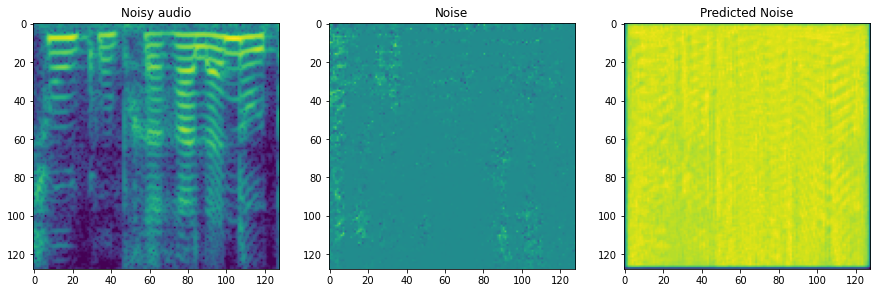

In [ ]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
index = 33
fig.set_figheight(6)
fig.set_figwidth(15)
ax1.imshow(np.squeeze(test_Xin[index]))
ax2.imshow(np.squeeze(test_Xout[index]))
ax3.imshow(np.squeeze(outputs[index].cpu().detach()))
ax1.title.set_text('Noisy audio')
ax2.title.set_text('Noise')
ax3.title.set_text('Predicted Noise')

22050


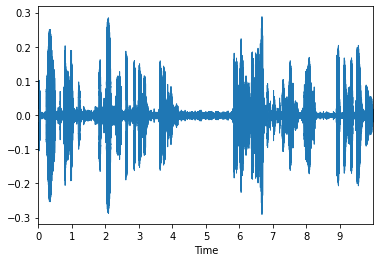

In [ ]:
import librosa
import librosa.display
import IPython as ip

y1, sample_rate1 = librosa.load("/content/drive/MyDrive/TP4 denoising/train-speech/train/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap04_52_.wav", mono=True)
y2, sample_rate2 = librosa.load("/content/drive/MyDrive/TP4 denoising/train-noise/train/street_pedestrian-helsinki-146-4391-a.wav", mono=True)

# MERGE
librosa.display.waveplot((y1+y2)/2, sr=int((sample_rate1+sample_rate2)/2))

# REPRODUCE
print(sample_rate1)
ip.display.Audio((y1+y2)/2, rate=int((sample_rate1+sample_rate2)/2))

In [ ]:
sf.write('mixed.wav',(y1+y2)/2, samplerate=int((sample_rate1+sample_rate2)/2))

In [ ]:
list_files = os.listdir("/content/noisy_aud")
audio = audio_files_to_numpy("/content/noisy_aud", list_files, 8000,8064, 8064)

dim_square_spec = int(255 / 2) + 1
print(dim_square_spec)

# Amplitude and phase of the sounds
m_amp_db_audio,  m_pha_audio = audio_to_matrix_spectrogram(audio, dim_square_spec, 255, 63)

# Scaling
X_in = scaled_input(m_amp_db_audio)

#Reshape to 128x128
X_in = X_in.reshape(X_in.shape[0],1,X_in.shape[1],X_in.shape[2])

# predict the nois spectogram
X_pred = model(torch.from_numpy(X_in).float().to(device))

# Rescale
inv_sca_X_pred = inv_scaled_output(X_pred)

# noisy audio - noise (difference of spectogram amplitudes)
X_denoise = torch.from_numpy(m_amp_db_audio).float().to(device) - inv_sca_X_pred[:,0,:,:]

#Reconstruct audio from denoised spectrogram and phase
reconstruction = spectrogram_to_audio(X_denoise.cpu().detach().numpy() , m_pha_audio, 8064, 63)
#Number of frames

nb_samples = reconstruction.shape[0]
#Save all frames in one file
denoise_long = reconstruction.reshape(1, nb_samples * 8064)*10
sf.write("/content/denoised/outuneti.wav", denoise_long[0, :], 8000)

128


In [ ]:
ip.display.Audio('/content/denoised/outuneti.wav')

In [ ]:
ip.display.Audio('/content/noisy/outunet2.wav')

In [ ]:
ip.display.Audio('/content/noisy_aud/mixed.wav')

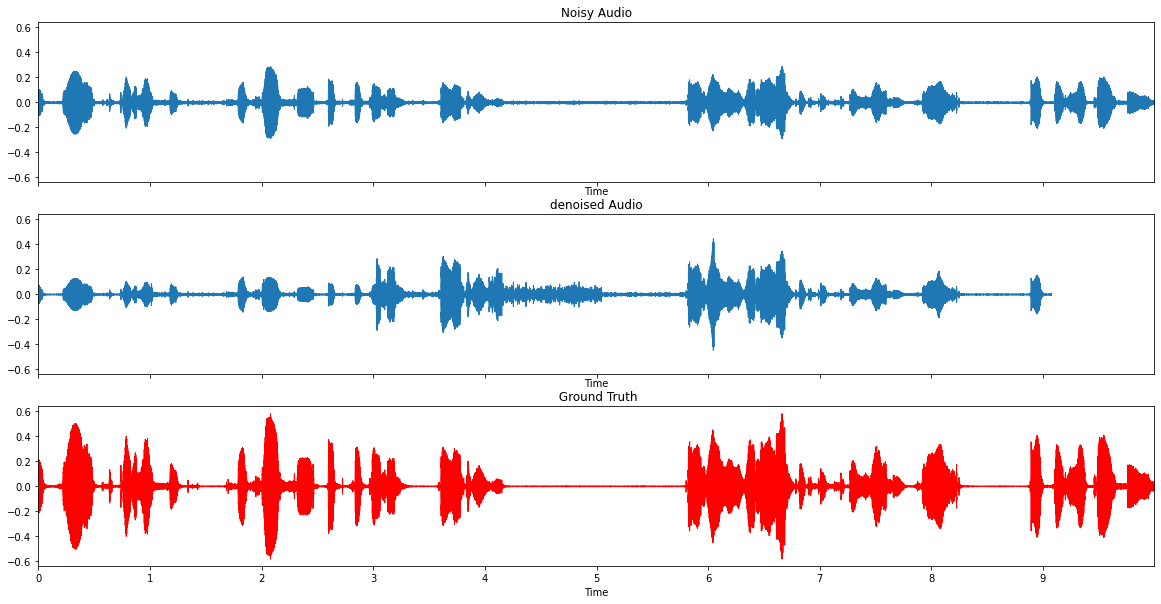

In [ ]:
denoised_audio, sr = librosa.load('/content/denoised/outuneti.wav', mono=True)
noisy_audio, sr = librosa.load('/content/noisy_aud/mixed.wav', mono=True)
fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True,figsize=(20,10))
ax[0].set(title='Noisy Audio')
ax[0].label_outer()
librosa.display.waveplot(noisy_audio, sr=sr,alpha=1, ax=ax[0])
ax[1].set(title='denoised Audio')
ax[1].label_outer()
librosa.display.waveplot(denoised_audio, sr=sr,alpha=1, ax=ax[1])
ax[2].set(title=' Ground Truth')
ax[2].label_outer()
librosa.display.waveplot(y1, sr=sample_rate1,color='r',alpha=1, ax=ax[2])

# Tensorflow implementation

In [ ]:
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
import tensorflow as tf

def Unet(input_size = (128,128,1)):
    out_channels = 16

    inputs = Input(input_size)
    conv1 = Conv2D(out_channels, 3, padding = 'same')(inputs)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    conv1 = Conv2D(out_channels, 3, padding = 'same')(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(out_channels*2, 3, padding = 'same')(pool1)
    conv2 = LeakyReLU(alpha=0.2)(conv2)
    conv2 = Conv2D(out_channels*2, 3, padding = 'same')(conv2)
    conv2 = LeakyReLU(alpha=0.2)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(out_channels*4, 3, padding = 'same')(pool2)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    conv3 = Conv2D(out_channels*4, 3, padding = 'same')(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(out_channels*8, 3, padding = 'same')(pool3)
    conv4 = LeakyReLU(alpha=0.2)(conv4)
    conv4 = Conv2D(out_channels*8, 3, padding = 'same')(conv4)
    conv4 = LeakyReLU(alpha=0.2)(conv4)
    drop4 = Dropout(0.3)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(out_channels*16, 3, padding = 'same')(pool4)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    conv5 = Conv2D(out_channels*16, 3, padding = 'same')(conv5)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    drop5 = Dropout(0.3)(conv5)

    up6 = Conv2D(out_channels*8, 2, padding = 'same')(UpSampling2D(size = (2,2))(drop5))
    up6 = LeakyReLU(alpha=0.2)(up6)
    concat1 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(out_channels*8, 3, padding = 'same')(concat1)
    conv6 = LeakyReLU(alpha=0.2)(conv6)
    conv6 = Conv2D(out_channels*8, 3, padding = 'same')(conv6)
    conv6 = LeakyReLU(alpha=0.2)(conv6)
    up7 = Conv2D(out_channels*4, 2, padding = 'same')(UpSampling2D(size = (2,2))(conv6))
    up7 = LeakyReLU(alpha=0.2)(up7)
    concat2 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(out_channels*4, 3, padding = 'same')(concat2)
    conv7 = LeakyReLU(alpha=0.2)(conv7)
    conv7 = Conv2D(out_channels*4, 3, padding = 'same')(conv7)
    conv7 = LeakyReLU(alpha=0.2)(conv7)
    up8 = Conv2D(out_channels*2, 2, padding = 'same')(UpSampling2D(size = (2,2))(conv7))
    up8 = LeakyReLU(alpha=0.2)(up8)
    concat3 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(out_channels*2, 3, padding = 'same')(concat3)
    conv8 = LeakyReLU(alpha=0.2)(conv8)
    conv8 = Conv2D(out_channels*2, 3, padding = 'same')(conv8)
    conv8 = LeakyReLU(alpha=0.2)(conv8)

    up9 = Conv2D(out_channels, 2, padding = 'same')(UpSampling2D(size = (2,2))(conv8))
    up9 = LeakyReLU(alpha=0.2)(up9)
    concat4 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(out_channels, 3, padding = 'same')(concat4)
    conv9 = LeakyReLU(alpha=0.2)(conv9)
    conv9 = Conv2D(out_channels, 3, padding = 'same')(conv9)
    conv9 = LeakyReLU(alpha=0.2)(conv9)
    conv9 = Conv2D(2, 3, padding = 'same')(conv9)
    conv9 = LeakyReLU(alpha=0.2)(conv9)
    output = Conv2D(1, 1, activation = 'tanh')(conv9)

    model = Model(inputs,output)

    model.compile(optimizer = 'adam', loss = tf.keras.losses.Huber(), metrics = ['mse'])

    return model

In [ ]:
model = Unet()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_48 (Conv2D)             (None, 128, 128, 16  160         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_46 (LeakyReLU)     (None, 128, 128, 16  0           ['conv2d_48[0][0]']              
                                )                                                           

In [ ]:
# load data
X_noisy_audio = np.load('/content/drive/MyDrive/sinal-processing-project/spectogram/noisy_voice_amp_db.npy')
X_clean_naudio = np.load('/content/drive/MyDrive/sinal-processing-project/spectogram/voice_amp_db.npy')
# noise
X_noise = X_noisy_audio - X_clean_naudio

#Check distribution
print(stats.describe(X_noisy_audio.reshape(-1,1)))
print(stats.describe(X_noise.reshape(-1,1)))

DescribeResult(nobs=81920000, minmax=(array([-80.]), array([0.])), mean=array([-50.09063744]), variance=array([229.63890262]), skewness=array([0.25145882]), kurtosis=array([-0.13898873]))
DescribeResult(nobs=81920000, minmax=(array([-76.0737]), array([72.5340954])), mean=array([2.61653424]), variance=array([52.96059301]), skewness=array([1.39687674]), kurtosis=array([4.69389232]))


In [ ]:
# Scale to [1,1]
X_noisy_audio = scaled_input(X_noisy_audio)
X_noise = scaled_output(X_noise)
print(stats.describe(X_noisy_audio.reshape(-1,1)))
print(stats.describe(X_noise.reshape(-1,1)))

DescribeResult(nobs=81920000, minmax=(array([-0.6]), array([1.])), mean=array([-0.00181275]), variance=array([0.09185556]), skewness=array([0.25145882]), kurtosis=array([-0.13898873]))
DescribeResult(nobs=81920000, minmax=(array([-0.96431341]), array([0.84797677])), mean=array([-0.00467641]), variance=array([0.00787635]), skewness=array([1.39687674]), kurtosis=array([4.69389232]))


In [ ]:
# Reshape to 128x128 (Unet's input size)
X_noisy_audio = X_noisy_audio[:,:,:]
X_noisy_audio = X_noisy_audio.reshape(X_noisy_audio.shape[0],X_noisy_audio.shape[1],X_noisy_audio.shape[2],1)
X_noise = X_noise[:,:,:]
X_noise = X_noise.reshape(X_noise.shape[0],X_noise.shape[1],X_noise.shape[2],1)
X_train, X_test, y_train, y_test = train_test_split(X_noisy_audio, X_noise, test_size=0.1, random_state=1) # 90% , 10% split

In [ ]:
tensorflow_model = Unet()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint = ModelCheckpoint('/content/drive/MyDrive/sinal-processing-project/checkpoints/tensorflow_model.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
# train fr 200 epochs
tensorflow_model = Unet()
history = tensorflow_model.fit(X_train, y_train, epochs=200, batch_size=64, shuffle=True, callbacks=[checkpoint], verbose=1, validation_data=(X_test, y_test))

Epoch 1/200
71/71 [==============================] - ETA: 0s - loss: 0.0039 - mse: 0.0079
Epoch 1: val_loss improved from inf to 0.00369, saving model to /content/drive/MyDrive/sinal-processing-project/checkpoints/tensorflow_model.h5
71/71 [==============================] - 19s 253ms/step - loss: 0.0039 - mse: 0.0079 - val_loss: 0.0037 - val_mse: 0.0074
Epoch 2/200
71/71 [==============================] - ETA: 0s - loss: 0.0035 - mse: 0.0071
Epoch 2: val_loss improved from 0.00369 to 0.00307, saving model to /content/drive/MyDrive/sinal-processing-project/checkpoints/tensorflow_model.h5
71/71 [==============================] - 18s 256ms/step - loss: 0.0035 - mse: 0.0071 - val_loss: 0.0031 - val_mse: 0.0061
Epoch 3/200
71/71 [==============================] - ETA: 0s - loss: 0.0031 - mse: 0.0063
Epoch 3: val_loss improved from 0.00307 to 0.00289, saving model to /content/drive/MyDrive/sinal-processing-project/checkpoints/tensorflow_model.h5
71/71 [==============================] - 18s 2

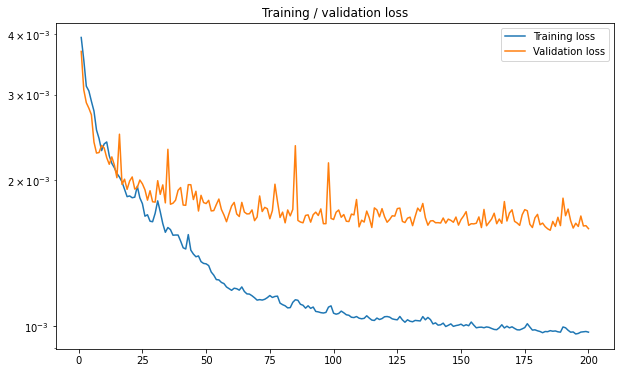

In [ ]:
plt.figure(figsize=(10,6))
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.yscale('log')
plt.title('Training / validation loss')
plt.legend()
plt.show()

The training is not perfectly stable, probable due to the chose of the loss function

In [ ]:
model_struct = tensorflow_model.to_json()
with open("/content/drive/MyDrive/sinal-processing-project/checkpoints/mod_unet_last_weights.json", "w") as json_file:
    json_file.write(model_struct)
tensorflow_model.load_weights('/content/drive/MyDrive/sinal-processing-project/checkpoints/tensorflow_model.h5')

In [ ]:
X_pred_test = tensorflow_model.predict(X_test)

16/16 [==============================] - 1s 31ms/step


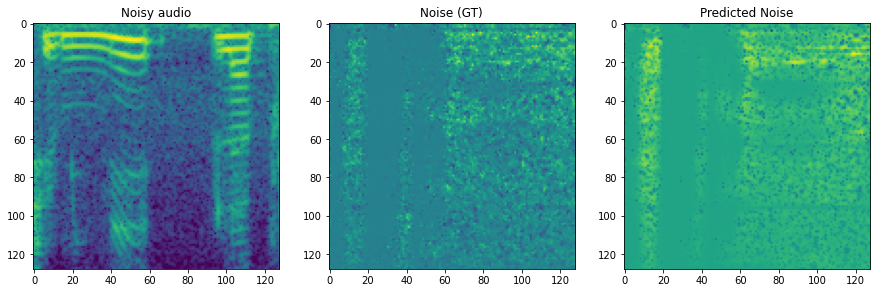

In [ ]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
index = 9
fig.set_figheight(6)
fig.set_figwidth(15)
ax1.imshow(np.squeeze(X_noisy_audio[index]))
ax2.imshow(np.squeeze(y_test[index]))
ax3.imshow(np.squeeze(X_pred_test[index]))
ax1.title.set_text('Noisy audio')
ax2.title.set_text('Noise (GT)')
ax3.title.set_text('Predicted Noise')

22050


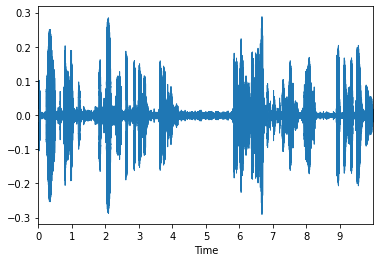

In [ ]:
import librosa
import librosa.display
import IPython as ip

y1, sample_rate1 = librosa.load("/content/drive/MyDrive/TP4 denoising/train-speech/train/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap04_52_.wav", mono=True)
y2, sample_rate2 = librosa.load("/content/drive/MyDrive/TP4 denoising/train-noise/train/street_pedestrian-helsinki-146-4391-a.wav", mono=True)

# MERGE
librosa.display.waveplot((y1+y2)/2, sr=int((sample_rate1+sample_rate2)/2))

# REPRODUCE
print(sample_rate1)
ip.display.Audio((y1+y2)/2, rate=int((sample_rate1+sample_rate2)/2))


In [ ]:
sf.write('mixed.wav',(y1+y2)*0.8/2, samplerate=int((sample_rate1+sample_rate2)/2))

In [ ]:
list_files = os.listdir("/content/noisy_aud")
audio = audio_files_to_numpy("/content/noisy_aud", list_files, 8000,8064, 8064)

dim_square_spec = int(255 / 2) + 1
print(dim_square_spec)

# Amplitude and phase of the sounds
m_amp_db_audio,  m_pha_audio = audio_to_matrix_spectrogram(audio, dim_square_spec, 255, 63)

# Scaling
X_in = scaled_input(m_amp_db_audio)

#Reshape to 128x128
X_in = X_in.reshape(X_in.shape[0],X_in.shape[1],X_in.shape[2],1)

# predict the nois spectogram
X_pred = tensorflow_model.predict(X_in)

# Rescale
inv_sca_X_pred = inv_scaled_output(X_pred)

# noisy audio - noise (difference of spectogram amplitudes)
X_denoise = m_amp_db_audio- inv_sca_X_pred[:,0,:,:]

# Reconstruct audio from denoised spectrogram and phase
reconstruction = spectrogram_to_audio(X_denoise , m_pha_audio, 8064, 63)
#Number of frames

nb_samples = reconstruction.shape[0]
#Save all frames in one file
denoise_long = reconstruction.reshape(1, nb_samples * 8064)*10
sf.write("/content/denoised/outuneti.wav", denoise_long[0, :], 8000)

128
1/1 [==============================] - 0s 18ms/step


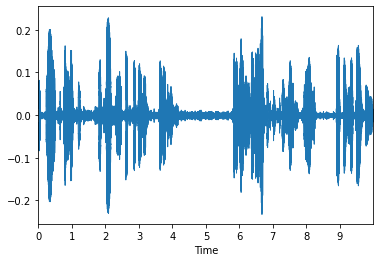

In [ ]:
ip.display.Audio('/content/nsy/mixed.wav')
noisy_audio, sr = librosa.load('/content/nsy/mixed.wav', mono=True)
librosa.display.waveplot(noisy_audio, sr=sr)

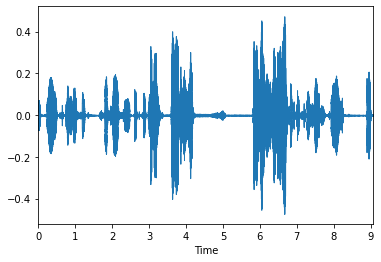

In [ ]:
ip.display.Audio('/content/noisy/outn.wav')
denoised_audio, sr = librosa.load('/content/noisy/outn.wav', mono=True)
librosa.display.waveplot(denoised_audio, sr=sr)

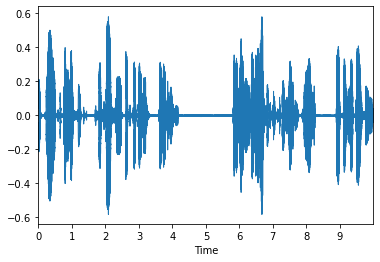

In [ ]:
# GT
librosa.display.waveplot(y1, sr=sample_rate1)

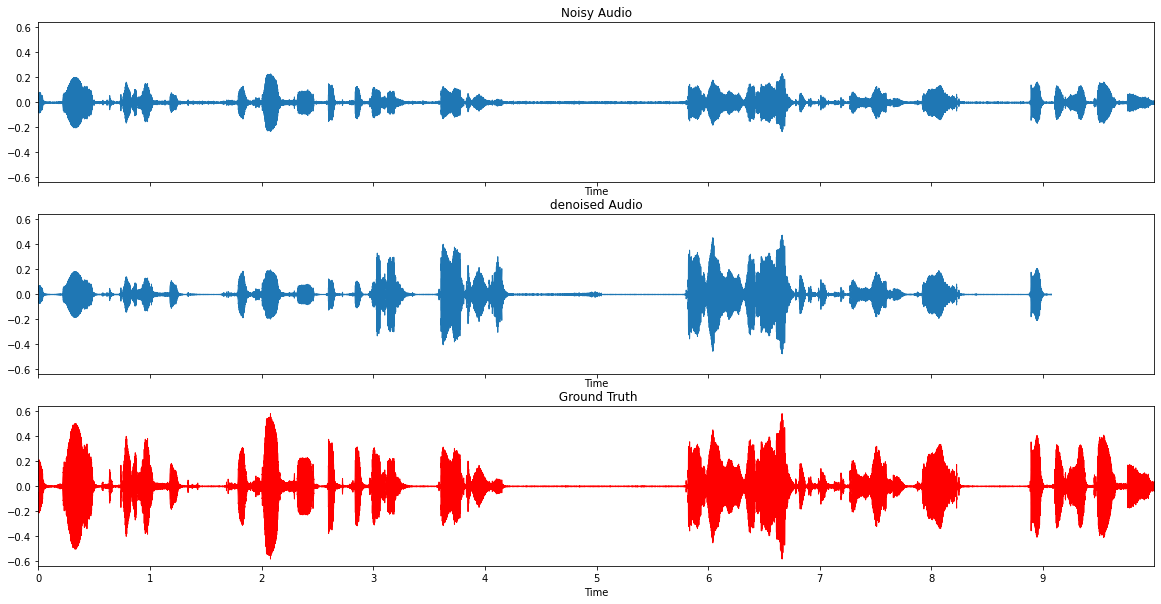

In [ ]:
fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True,figsize=(20,10))
ax[0].set(title='Noisy Audio')
ax[0].label_outer()
librosa.display.waveplot(noisy_audio, sr=sr,alpha=1, ax=ax[0])
ax[1].set(title='denoised Audio')
ax[1].label_outer()
librosa.display.waveplot(denoised_audio, sr=sr,alpha=1, ax=ax[1])
ax[2].set(title=' Ground Truth')
ax[2].label_outer()
librosa.display.waveplot(y1, sr=sample_rate1,color='r',alpha=1, ax=ax[2])